In [9]:
import os
import json
from typing import List

import pandas

def collect_stat(benchmark_result_dir:str, csv_path=None):
    if csv_path is None:
        csv_path = os.path.join(benchmark_result_dir, "summary.csv")
        
    all_data = []
    # Loop through the items in the directory
    for item in os.listdir(benchmark_result_dir):
        subdir_full_path = os.path.join(benchmark_result_dir, item)
        
        # Check if the item is a subdirectory
        if not (item.startswith('nreqs') and os.path.isdir(subdir_full_path)):
            print(f'skipping {item}')
            continue
        
        result_json_file = os.path.join(subdir_full_path, 'benchmark.json')
        if not os.path.isfile(result_json_file):
            print(f'skipping {item}')
            continue
        
        # Parse dir name to configs 
        configs = {}
        pairs = item.split('.')
        for pair in pairs:
            key, value = pair.split('_')
            try:
                value = int(value)
            except ValueError:
                pass
            # Add the key-value pair to the dictionary
            configs[key] = value
            
        # Read the benchmark result
        with open(result_json_file) as file:
            metrics = json.load(file)
            
        all_data.append({**configs, **metrics})
        
    df = pandas.DataFrame(all_data)
    df.to_csv(csv_path, index=False)
    
    return csv_path

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Iterable, Union, List, Dict

def plot_multi_barchart(group_ids:Union[List[int], List[str]],
                        data_dict:Dict[str, Iterable], ax:plt.Axes=None,
                        put_text_on_bars:bool=False):
    ngrps = len(group_ids)
    nbars_per_grp = len(data_dict)
    bar_width = 1. / (nbars_per_grp + 1)
    # opacity = 0.8
    opacity = 1.0

    leftmost = np.arange(ngrps) - (nbars_per_grp*bar_width / 2)

    if ax is None:
        _, ax = plt.subplots()

    for idx, (name, data) in enumerate(data_dict.items()):
        assert len(data) == ngrps
        center_offset_to_leftmost = bar_width / 2 + bar_width*idx
        bars = plt.bar(
            leftmost + center_offset_to_leftmost , # center of the bars
            data, # heights of the bars
            bar_width,
            alpha=opacity,
            label=name
        )
        if put_text_on_bars:
            for i in range(ngrps):
                # print(data[i])
                plt.text(leftmost[i]+center_offset_to_leftmost, data[i], f'{data[i]:.1f}', ha='center', size='x-small')
    
    ax.set_xticks(np.arange(ngrps), group_ids)
    
    return ax

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def plot_figure(csv_path:str,
                metric_plot='generate_tok_per_sec',
                y_lim=None,
                ftype='line'):
    assert ftype in {'line', 'bar'}
    # metric_plot = 'throughput'
    line_styles = ['-o', '-D', '->']
    df = pd.read_csv(csv_path)
    condition_dict = { 
        'vLLM-RA (ours)': (df['backend']=='vllm+'),
        'vLLM+': (df['backend']=='vllm+pc'), 
        'vLLM': (df['backend']=='vllm')
    }
    
    data_dict = {}
    for name, cond in condition_dict.items():
        # print(df)
        # print(df['reqrate'])
        view = df[cond].sort_values('prefixlen')
        x = view['prefixlen'].to_numpy(dtype=np.int32)
        y = view[metric_plot].to_numpy(dtype=np.float32)
        data_dict[name] = (x, y)

    try:
        plt_context = plt.style.context(['light', 'grid'])
        with plt_context:
            pass
    except:
        import contextlib
        plt_context = contextlib.nullcontext()

    with plt_context:
        figure, ax = plt.subplots()
        if ftype == 'line':
            for idx, (label, data) in enumerate(data_dict.items()):
                x, y = data
                ax.plot(x, y, line_styles[idx], label=label)
            if y_lim:
                ax.set_ylim(y_lim)
        else:
            bar_dict = {k:v for k, (_, v) in data_dict.items()}
            group_ids = list(data_dict.values())[0][0]
            plot_multi_barchart(group_ids=group_ids, data_dict=bar_dict, ax=ax)
        
        ax.set_ylabel('Throughput (tok/s)')
        ax.set_xlabel('System Prompt Length (#tokens)')
        ax.legend()
    plt.tight_layout()
    plt.show()

NVIDIA-A40 Llama-2-13b-hf


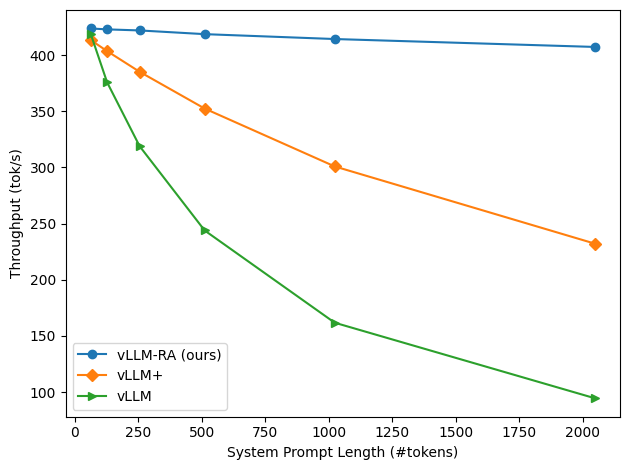

NVIDIA-A40 Llama-2-7b-hf


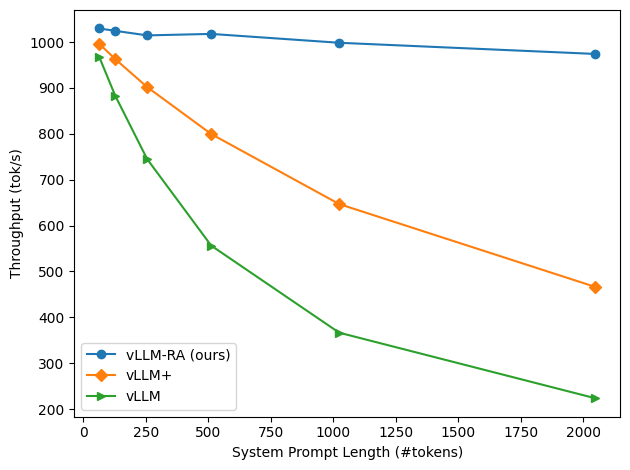

NVIDIA-A100-PCIE-40GB Llama-2-7b-hf


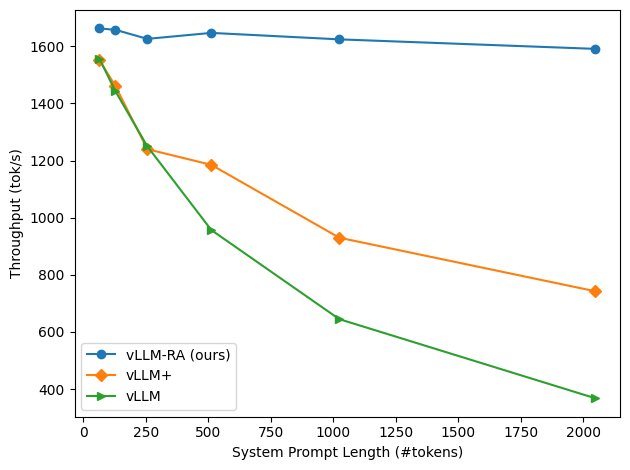

NVIDIA-A100-PCIE-40GB Llama-2-13b-hf


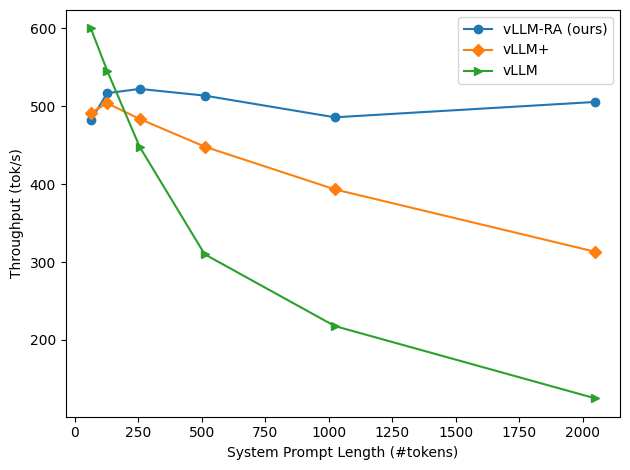

In [12]:
bench='noninteractive_bench_sharegpt'
exp_root = f'../outputs/{bench}'

csv_root = f'../stat/{bench}'
os.makedirs(csv_root, exist_ok=True)

collect = True

if collect:
    for gpu in os.listdir(exp_root):
        gpu_dir = os.path.join(exp_root, gpu)
        for model in os.listdir(gpu_dir):
            benchmark_result_dir = os.path.join(gpu_dir, model)
            csv_path = os.path.join(csv_root, f'{gpu}.{model}.csv')
            collect_stat(benchmark_result_dir, csv_path=csv_path)

for file in os.listdir(csv_root):
    if file.endswith('.csv'):
        gpu, model, _ = file.split('.')
        csv_path = os.path.join(csv_root,file)
        print(gpu, model)
        plot_figure(csv_path, ftype='line')